# Autoencoder
기본적인 Autoencoder를 PyTorch로 구현

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

%matplotlib inline

## Dataset
사용된 데이터는 MNIST이며, __f(x) = x__의 형태를 최대한 구현하도록 할 예정
<br><img src="https://camo.githubusercontent.com/96616324d5683a2e1efe9c469ca645e119b90602/687474703a2f2f75706c6f61642d696d616765732e6a69616e7368752e696f2f75706c6f61645f696d616765732f333632333732302d356534363937376437663839303566392e706e673f696d6167654d6f6772322f6175746f2d6f7269656e742f7374726970253743696d61676556696577322f322f772f31323430">

In [2]:
# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

데이터 확인을 위해 MNIST 데이터중 1개를 출력

torch.Size([60000, 28, 28])
torch.Size([60000])


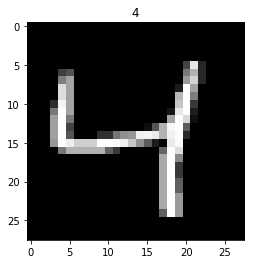

In [3]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

## Architecture
기본적인 구조는 다음과 같다
- Encoder: 28*28의 이미지를 128개의 Feature로부터 3개의 Feature까지 압축한다.
- Decoder: 3개의 압축된 Feature를 128개의 Feature로 복원(Reconstruct)한다.

Autoencoder가 의미를 가질 수 있는 이유는 데이터의 특징을 찾아낼 수 있다는 점이다.
- Encoder vs Decoder
<br>
<img src="https://camo.githubusercontent.com/f4561bdc2921a504cb7209dbe1102bdd5107ff3e/687474703a2f2f75706c6f61642d696d616765732e6a69616e7368752e696f2f75706c6f61645f696d616765732f333632333732302d383630393636356435343834636132382e706e673f696d6167654d6f6772322f6175746f2d6f7269656e742f7374726970253743696d61676556696577322f322f772f31323430">
<img src="https://camo.githubusercontent.com/18dea55a9286cdf3067668b869d5770e6b080342/687474703a2f2f75706c6f61642d696d616765732e6a69616e7368752e696f2f75706c6f61645f696d616765732f333632333732302d353562336362613338366631653361352e706e673f696d6167654d6f6772322f6175746f2d6f7269656e742f7374726970253743696d61676556696577322f322f772f31323430">

- Encoder의 Actual Output<br>
<img src="https://camo.githubusercontent.com/0e2319d6ebe0f11d7e2518e24350c7251ef45a60/687474703a2f2f75706c6f61642d696d616765732e6a69616e7368752e696f2f75706c6f61645f696d616765732f333632333732302d626462366161396237653939626134612e706e673f696d6167654d6f6772322f6175746f2d6f7269656e742f7374726970253743696d61676556696577322f322f772f31323430">

In [4]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

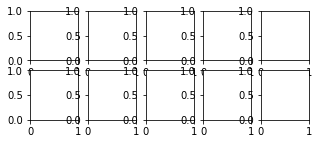

In [5]:
# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

In [6]:
# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0])

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

Epoch:  0 | train loss: 0.2320


Epoch:  0 | train loss: 0.0604


Epoch:  0 | train loss: 0.0567


Epoch:  0 | train loss: 0.0507


Epoch:  0 | train loss: 0.0426


Epoch:  0 | train loss: 0.0448


Epoch:  0 | train loss: 0.0471


Epoch:  0 | train loss: 0.0420


Epoch:  0 | train loss: 0.0436


Epoch:  0 | train loss: 0.0386


Epoch:  1 | train loss: 0.0392


Epoch:  1 | train loss: 0.0361


Epoch:  1 | train loss: 0.0404


Epoch:  1 | train loss: 0.0433


Epoch:  1 | train loss: 0.0374


Epoch:  1 | train loss: 0.0389


Epoch:  1 | train loss: 0.0354


Epoch:  1 | train loss: 0.0323


Epoch:  1 | train loss: 0.0399


Epoch:  1 | train loss: 0.0369


Epoch:  2 | train loss: 0.0340


Epoch:  2 | train loss: 0.0359


Epoch:  2 | train loss: 0.0363


Epoch:  2 | train loss: 0.0365


Epoch:  2 | train loss: 0.0335


Epoch:  2 | train loss: 0.0327


Epoch:  2 | train loss: 0.0356


Epoch:  2 | train loss: 0.0333


Epoch:  2 | train loss: 0.0358


Epoch:  2 | train loss: 0.0361


Epoch:  3 | train loss: 0.0327


Epoch:  3 | train loss: 0.0328


Epoch:  3 | train loss: 0.0354


Epoch:  3 | train loss: 0.0322


Epoch:  3 | train loss: 0.0379


Epoch:  3 | train loss: 0.0356


Epoch:  3 | train loss: 0.0324


Epoch:  3 | train loss: 0.0358


Epoch:  3 | train loss: 0.0359


Epoch:  3 | train loss: 0.0324


Epoch:  4 | train loss: 0.0331


Epoch:  4 | train loss: 0.0347


Epoch:  4 | train loss: 0.0355


Epoch:  4 | train loss: 0.0321


Epoch:  4 | train loss: 0.0359


Epoch:  4 | train loss: 0.0350


Epoch:  4 | train loss: 0.0335


Epoch:  4 | train loss: 0.0327


Epoch:  4 | train loss: 0.0332


Epoch:  4 | train loss: 0.0343


Epoch:  5 | train loss: 0.0346


Epoch:  5 | train loss: 0.0358


Epoch:  5 | train loss: 0.0340


Epoch:  5 | train loss: 0.0366


Epoch:  5 | train loss: 0.0367


Epoch:  5 | train loss: 0.0360


Epoch:  5 | train loss: 0.0364


Epoch:  5 | train loss: 0.0330


Epoch:  5 | train loss: 0.0328


Epoch:  5 | train loss: 0.0342


Epoch:  6 | train loss: 0.0337


Epoch:  6 | train loss: 0.0380


Epoch:  6 | train loss: 0.0311


Epoch:  6 | train loss: 0.0341


Epoch:  6 | train loss: 0.0387


Epoch:  6 | train loss: 0.0311


Epoch:  6 | train loss: 0.0328


Epoch:  6 | train loss: 0.0334


Epoch:  6 | train loss: 0.0301


Epoch:  6 | train loss: 0.0309


Epoch:  7 | train loss: 0.0347


Epoch:  7 | train loss: 0.0331


Epoch:  7 | train loss: 0.0342


Epoch:  7 | train loss: 0.0331


Epoch:  7 | train loss: 0.0359


Epoch:  7 | train loss: 0.0291


Epoch:  7 | train loss: 0.0311


Epoch:  7 | train loss: 0.0321


Epoch:  7 | train loss: 0.0327


Epoch:  7 | train loss: 0.0362


Epoch:  8 | train loss: 0.0330


Epoch:  8 | train loss: 0.0329


Epoch:  8 | train loss: 0.0356


Epoch:  8 | train loss: 0.0304


Epoch:  8 | train loss: 0.0315


Epoch:  8 | train loss: 0.0299


Epoch:  8 | train loss: 0.0362


Epoch:  8 | train loss: 0.0289


Epoch:  8 | train loss: 0.0298


Epoch:  8 | train loss: 0.0332


Epoch:  9 | train loss: 0.0331


Epoch:  9 | train loss: 0.0330


Epoch:  9 | train loss: 0.0316


Epoch:  9 | train loss: 0.0292


Epoch:  9 | train loss: 0.0296


Epoch:  9 | train loss: 0.0309


Epoch:  9 | train loss: 0.0325


Epoch:  9 | train loss: 0.0313


Epoch:  9 | train loss: 0.0312


Epoch:  9 | train loss: 0.0348


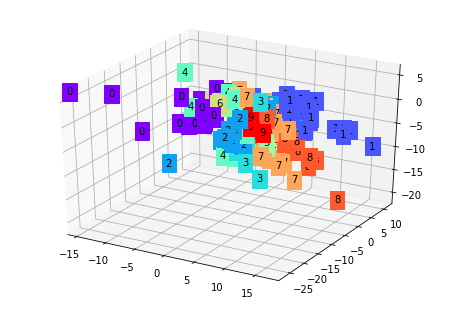

In [7]:
# visualize in 3D plot
view_data = Variable(train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.)
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()